In [151]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np, h5py

In [152]:
import matplotlib as mpl
from sklearn.datasets import load_iris
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score

In [153]:
class GMM:
    def __init__(self,Data,K,weights = None,means = None,covars = None):
        """
        这是GMM（高斯混合模型）类的构造函数
        :param Data: 训练数据
        :param K: 高斯分布的个数
        :param weigths: 每个高斯分布的初始概率（权重）
        :param means: 高斯分布的均值向量
        :param covars: 高斯分布的协方差矩阵集合
        """
        self.Data = Data
        self.K = K
        if weights is not None:
            self.weights = weights
        else:
            self.weights  = np.random.rand(self.K)
            self.weights /= np.sum(self.weights)        # 归一化
        col = np.shape(self.Data)[1]
        if means is not None:
            self.means = means
        else:
            self.means = []
            for i in range(self.K):
                mean = np.random.rand(col)
                #mean = mean / np.sum(mean)        # 归一化
                self.means.append(mean)
        if covars is not None:
            self.covars = covars
        else:
            self.covars  = []
            for i in range(self.K):
                cov = np.random.rand(col,col)
                #cov = cov / np.sum(cov)                    # 归一化
                self.covars.append(cov)                     # cov是np.array,但是self.covars是lis
                
                
    def Gaussian(self,x,mean,cov):
        """
        这是自定义的高斯分布概率密度函数
        :param x: 输入数据
        :param mean: 均值数组
        :param cov: 协方差矩阵
        :return: x的概率
        """
        dim = np.shape(cov)[0]
        # cov的行列式为零时的措施
        covdet = np.linalg.det(cov + np.eye(dim) * 0.001)
        covinv = np.linalg.inv(cov + np.eye(dim) * 0.001)
        xdiff = (x - mean).reshape((1,dim))
        # 概率密度
        prob = 1.0/(np.power(np.power(2*np.pi,dim)*np.abs(covdet),0.5))*\
               np.exp(-0.5*xdiff.dot(covinv).dot(xdiff.T))[0][0]
        return prob

    
    def GMM_EM(self):
        """
        这是利用EM算法进行优化GMM参数的函数
        :return: 返回各组数据的属于每个分类的概率
        """
        loglikelyhood = 0
        oldloglikelyhood = 1
        len,dim = np.shape(self.Data)
        # gamma表示第n个样本属于第k个混合高斯的概率
        gammas = [np.zeros(self.K) for i in range(len)]
        while np.abs(loglikelyhood-oldloglikelyhood) > 0.00000001:
            oldloglikelyhood = loglikelyhood
            # E-step
            for n in range(len):
                # respons是GMM的EM算法中的权重w，即后验概率
                respons = [self.weights[k] * self.Gaussian(self.Data[n], self.means[k], self.covars[k])
                                                    for k in range(self.K)]
                respons = np.array(respons)
                sum_respons = np.sum(respons)
                gammas[n] = respons/sum_respons
            # M-step
            for k in range(self.K):
                #nk表示N个样本中有多少属于第k个高斯
                nk = np.sum([gammas[n][k] for n in range(len)])
                # 更新每个高斯分布的概率
                self.weights[k] = 1.0 * nk / len
                # 更新高斯分布的均值
                self.means[k] = (1.0/nk) * np.sum([gammas[n][k] * self.Data[n] for n in range(len)], axis=0)
                xdiffs = self.Data - self.means[k]
                # 更新高斯分布的协方差矩阵
                self.covars[k] = (1.0/nk)*np.sum([gammas[n][k]*xdiffs[n].reshape((dim,1)).dot(xdiffs[n].reshape((1,dim))) for n in range(len)],axis=0)
            loglikelyhood = []
            for n in range(len):
                tmp = [np.sum(self.weights[k]*self.Gaussian(self.Data[n],self.means[k],self.covars[k])) for k in range(self.K)]
                tmp = np.log(np.array(tmp))
                loglikelyhood.append(list(tmp))
            loglikelyhood = np.sum(loglikelyhood)
        for i in range(len):
            gammas[i] = gammas[i]/np.sum(gammas[i])
        self.posibility = gammas
        self.prediction = [np.argmax(gammas[i]) for i in range(len)]


In [154]:
def run_main():
    """
        这是主函数
    """
    # 导入Iris数据集
    iris = load_iris()
    label = np.array(iris.target)
    data = np.array(iris.data)
    print("Iris dataset labels：\n",label)


    # 对数据进行预处理
    data = Normalizer().fit_transform(data)


    # 数据可视化
    plt.scatter(data[:,1],data[:,2],c = label)
    plt.title("Iris dataset visualzation")
    plt.show()

    
    # GMM模型
    K = 3
    gmm = GMM(data,K)
    gmm.GMM_EM()
    y_pre = gmm.prediction
    print("GMM Prediction：\n",y_pre)
    print("GMM Correction Ratio：\n",accuracy_score(label,y_pre))
    plt.scatter(data[:, 1], data[:, 2], c=y_pre)
    plt.title("GMM Results visualization")
    plt.show()
    


Iris dataset labels：
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


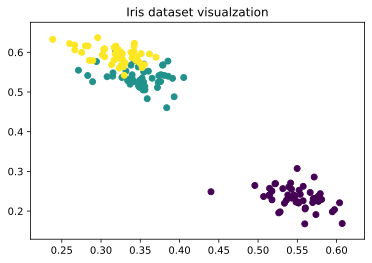

GMM Prediction：
 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
GMM Correction Ratio：
 0.3333333333333333


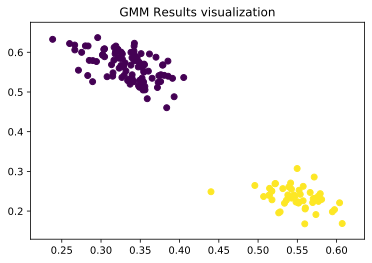

In [70]:
if __name__ == '__main__':
    run_main()


### First TRY: 输入是分bin后每个bin里的hitTime数目， 效果不好...

In [156]:
### Load alpha/beta dataset
import h5py
with h5py.File("./data_base1/ab-0.h5") as fi:
    print(list(fi.keys()))
    
import pandas as pd
PETruth = pd.read_hdf("./data_base1/ab-0.h5", "PETruth").set_index("EventID")

ParticleTruth = pd.read_hdf("./data_base1/ab-0.h5", "ParticleTruth").set_index("EventID")

alpha_label = ParticleTruth.query("Alpha==1")
beta_label = ParticleTruth.query("Alpha==0")

alpha_data = PETruth.loc[alpha_label.index]
beta_data = PETruth.loc[beta_label.index]


['PETruth', 'ParticleTruth', 'Waveform']


In [157]:
## loop all alpha events
alpha_align_time = []
for i in range(9093):
    alpha_id = alpha_label.index[i]
    alpha_event = PETruth.loc[alpha_id]
    cont, edge = np.histogram(alpha_event['PETime'], bins=1000, range=(0,1000))
    alpha_align_time.append((np.argmax(cont)*2+1)/2.-200.)
alpha_align_time = np.array(alpha_align_time)
        
        
## loop all beta events
beta_align_time = []
for i in range(4598):
    beta_id = beta_label.index[i]
    beta_event = PETruth.loc[beta_id]
    cont, edge = np.histogram(beta_event['PETime'], bins=1000, range=(0,1000))

    beta_align_time.append((np.argmax(cont)*2+1)/2.-200)
beta_align_time = np.array(beta_align_time)


In [146]:
alpha_trainset = []; beta_trainset = [];
for i in range(100):
    align_alpha = [];
    alpha_id = alpha_label.index[i]
    alpha_event = PETruth.loc[alpha_id]
    for j in range(alpha_event['PETime'].values.shape[0]):
        if alpha_event['PETime'].values[j]-alpha_align_time[i]>160 and alpha_event['PETime'].values[j]-alpha_align_time[i]<400:
            align_alpha.append(alpha_event['PETime'].values[j]-alpha_align_time[i])
    cont, edge = np.histogram(align_alpha, bins=20, range=(220,320))
    alpha_trainset.append(cont)
    
    align_beta = [];
    beta_id = beta_label.index[i]
    beta_event = PETruth.loc[beta_id]
    for k in range(beta_event['PETime'].values.shape[0]):
        if beta_event['PETime'].values[k]-beta_align_time[i]>160 and beta_event['PETime'].values[k]-beta_align_time[i]<400:
            align_beta.append(beta_event['PETime'].values[k]-beta_align_time[i])
    cont, edge = np.histogram(align_beta, bins=20, range=(220,320))
    beta_trainset.append(cont)
    
alpha_trainset = np.array(alpha_trainset)
beta_trainset = np.array(beta_trainset)

In [147]:
dataset = np.vstack((alpha_trainset, beta_trainset))

In [148]:
label = [];
for i in range(200):
    if i<100:
        label.append(0);
    else:
        label.append(1);

#color_map = [];
#print(label[0][1])

#for i in range(200):
#    if label[0][i] == 1:
#        color_map.append("blue");
#    else:
#        color_map.append("green");


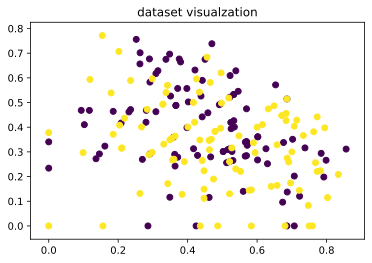

In [149]:
data_preprocess = Normalizer().fit_transform(dataset)

plt.scatter(data_preprocess[:,0],data_preprocess[:,1], c=label)
plt.title("dataset visualzation")
plt.show()

In [ ]:
K = 2
gmm = GMM(data_preprocess, K)
gmm.GMM_EM()
y_pre = gmm.prediction
print("GMM Prediction：\n",y_pre)
print("GMM Correction Ratio：\n",accuracy_score(label,y_pre))
plt.scatter(data_preprocess[:, 0], data_preprocess[:, 1], c=y_pre)
plt.title("GMM Results visualization")
plt.show()

### Second TRY: 输入是分bin后从最后开始每个bin占总数的比例

In [209]:
## input： 从尾巴开始每个bin逐个叠加的比例

alpha_trainset = []; beta_trainset = [];
for i in range(100):
    align_alpha = []; tail_ratio = [];
    alpha_id = alpha_label.index[i]
    alpha_event = PETruth.loc[alpha_id]
    for j in range(alpha_event['PETime'].values.shape[0]):
        if alpha_event['PETime'].values[j]-alpha_align_time[i]>160 and alpha_event['PETime'].values[j]-alpha_align_time[i]<400:
            align_alpha.append(alpha_event['PETime'].values[j]-alpha_align_time[i])
    cont, edge = np.histogram(align_alpha, bins=36, range=(220,400))
    for h in range(18):
        tmp = 0;
        for l in range(h):
            tmp += cont[17-l]
        tmp /= np.sum(cont)
        tail_ratio.append(tmp)
    alpha_trainset.append(tail_ratio)

for i in range(100):
    align_beta = []; tail_ratio = [];
    beta_id = beta_label.index[i]
    beta_event = PETruth.loc[beta_id]
    for k in range(beta_event['PETime'].values.shape[0]):
        if beta_event['PETime'].values[k]-beta_align_time[i]>160 and beta_event['PETime'].values[k]-beta_align_time[i]<400:
            align_beta.append(beta_event['PETime'].values[k]-beta_align_time[i])
    cont, edge = np.histogram(align_beta, bins=36, range=(220,400))
    for h in range(18):
        tmp = 0;
        for l in range(h):
            tmp += cont[17-l]
        tmp /= np.sum(cont)
        tail_ratio.append(tmp)
    beta_trainset.append(tail_ratio)
    
alpha_trainset = np.array(alpha_trainset)
beta_trainset = np.array(beta_trainset)

In [208]:
beta_trainset

array([[0.        , 0.        , 0.        , ..., 0.38461538, 0.57692308,
        0.76923077],
       [0.        , 0.04      , 0.04      , ..., 0.4       , 0.52      ,
        0.76      ],
       [0.        , 0.        , 0.        , ..., 0.4375    , 0.5625    ,
        0.875     ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.23333333, 0.46666667,
        0.7       ],
       [0.        , 0.        , 0.        , ..., 0.55555556, 0.61111111,
        0.83333333],
       [0.        , 0.        , 0.        , ..., 0.21428571, 0.35714286,
        0.64285714]])

In [210]:
dataset = np.vstack((alpha_trainset, beta_trainset))
label = [];
for i in range(200):
    if i<100:
        label.append(0);
    else:
        label.append(1);

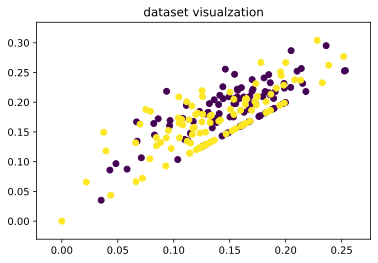

In [211]:
data_preprocess = Normalizer().fit_transform(dataset)

plt.scatter(data_preprocess[:,10],data_preprocess[:,11], c=label)
plt.title("dataset visualzation")
plt.show()

GMM Prediction：
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1]
GMM Correction Ratio：
 0.52


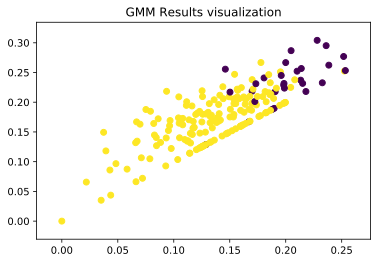

In [212]:
K = 2
gmm = GMM(data_preprocess, K)
gmm.GMM_EM()
y_pre = gmm.prediction
print("GMM Prediction：\n",y_pre)
print("GMM Correction Ratio：\n",accuracy_score(label,y_pre))
plt.scatter(data_preprocess[:, 10], data_preprocess[:, 11], c=y_pre)
plt.title("GMM Results visualization")
plt.show()

In [ ]:
### 分类效果还是不好，特征空间选取的不好～